In [121]:
# from google.colab import drive
# drive.mount('/content/drive')

In [122]:
folder_input_path = '/content/drive/My Drive/Colab Notebooks/4_Influencing_Signal/data-hrv-swell-kw/'
output_output_path = '/content/drive/My Drive/Colab Notebooks/4_Influencing_Signal/data-hrv-swell-kw/'
name = 'p25'

In [123]:
import numpy as np


def process_rr_intervals(df):
    # Assuming 'Time' is in seconds and 'RR' in milliseconds
    # Convert 'RR' to seconds for consistency in time units
    df['RR'] = df['RR'] / 1000  # Convert milliseconds to seconds

    # Calculate the differences for RMSSD and SDSD calculations
    df['RR_diff'] = df['RR'].diff().abs()

    # Create Interval ID based on minute intervals
    df['Interval_ID'] = df['Time'].apply(lambda x: int(x // 60)) + 1

    # Calculate SD1 and SD2
    # For SD1 and SD2, first, we need to calculate the RR(n) and RR(n+1) differences and sums for the Poincaré plot
    df['RR_n'] = df['RR'].shift(-1)
    df['diff_n_n+1'] = df['RR'] - df['RR_n']
    df['sum_n_n+1'] = df['RR'] + df['RR_n']

    # SD1 and SD2 calculations
    df['SD1'] = np.sqrt(0.5) * df['diff_n_n+1']
    df['SD2'] = np.sqrt(0.5) * df['sum_n_n+1']

    # Calculate HRV metrics for each interval
    hrv_metrics = df.groupby('Interval_ID').agg(
        MEAN_RR=('RR', 'mean'),
        MEDIAN_RR=('RR', 'median'),
        SDRR=('RR', 'std'),
        RMSSD=('RR_diff', lambda x: np.sqrt(np.mean(x**2))),
        SDSD=('RR_diff', 'std'),
        pNN50=('RR_diff', lambda x: sum(x > 0.05) / len(x)),
        pNN25=('RR_diff', lambda x: sum(x > 0.025) / len(x)),
        SD1=('SD1', 'std'),
        SD2=('SD2', 'std')
    )
    hrv_metrics['SDRR_RMSSD'] = hrv_metrics['SDRR'] / hrv_metrics['RMSSD']
    hrv_metrics['HR'] = 60 / hrv_metrics['MEAN_RR']

    # For the HRV dataset, we'll include all specified HRV metrics and Interval_ID in one dataset
    hrv_columns = ["Interval_ID", "MEAN_RR", "MEDIAN_RR", "SDRR", "RMSSD", "SDSD", "SDRR_RMSSD", "HR", "pNN50", "pNN25", "SD1", "SD2"]
    # Ensure the HRV metrics dataset has the correct structure
    hrv_df = hrv_metrics.reset_index()[hrv_columns]

    # For the RR dataset, we'll include Interval_ID and RR intervals in another dataset
    rr_columns = ["Interval_ID", "RR_Interval"]
    # Extracting RR intervals and their corresponding Interval_ID
    df['RR_Interval'] = df['RR'] * 1000 # Convert back from seconds to milliseconds
    rr_df = df.reset_index()[rr_columns]

    return hrv_df, rr_df

In [124]:
import pandas as pd

# File path of the RR interval data
file_path = folder_input_path + name + '.txt'
df = pd.read_csv(file_path, sep="\s+", header=None, names=['Time', 'RR'])

# Process the RR intervals and calculate HRV metrics
hrv_df, rr_df = process_rr_intervals(df)

# Save the HRV metrics and original RR intervals to CSV files
hrv_csv_path = output_output_path + name + '_HRV.csv'
rr_csv_path = output_output_path + name + '_RR.csv'
hrv_df.to_csv(hrv_csv_path, index=False)
rr_df.to_csv(rr_csv_path, index=False)

print(f"HRV metrics saved to {hrv_csv_path}")
print(f"Original RR intervals saved to {rr_csv_path}")

HRV metrics saved to /content/drive/My Drive/Colab Notebooks/4_Influencing_Signal/data-hrv-swell-kw/p25_HRV.csv
Original RR intervals saved to /content/drive/My Drive/Colab Notebooks/4_Influencing_Signal/data-hrv-swell-kw/p25_RR.csv


In [125]:
hrv_df.head()

,Interval_ID,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN50,pNN25,SD1,SD2
0,1,0.545514,0.546602,0.041894,0.009668,0.008012,4.333465,109.988034,0.012552,0.020921,0.006836,0.058767
1,2,0.576132,0.575539,0.021322,0.003883,0.002600,5.490550,104.142814,0.000000,0.000000,0.002754,0.030013
2,3,0.588070,0.579033,0.039416,0.005611,0.003939,7.025109,102.028750,0.000000,0.000000,0.003974,0.055601
3,4,0.592701,0.582784,0.046085,0.006721,0.005923,6.856331,101.231433,0.000000,0.020833,0.004763,0.065010
4,5,0.575912,0.578485,0.016489,0.005491,0.004432,3.002970,104.182541,0.000000,0.008333,0.003889,0.022993


In [126]:
rr_df.head(238)

,Interval_ID,RR_Interval
0,1,615.72266
1,1,556.42315
2,1,520.94738
3,1,502.99830
4,1,496.27891
...,...,...
233,1,640.59380
234,1,632.07257
235,1,616.70213
236,1,603.03794


In [127]:
# To determine the number of records per interval, we'll count the occurrences of each Interval_ID in the RR dataset
records_per_interval = rr_df.groupby('Interval_ID').size().reset_index(name='Records_Per_Interval')

# Displaying the count of records per interval
records_per_interval.head(100)

,Interval_ID,Records_Per_Interval
0,1,239
1,2,240
2,3,240
3,4,240
4,5,240
...,...,...
95,96,240
96,97,240
97,98,240
98,99,240


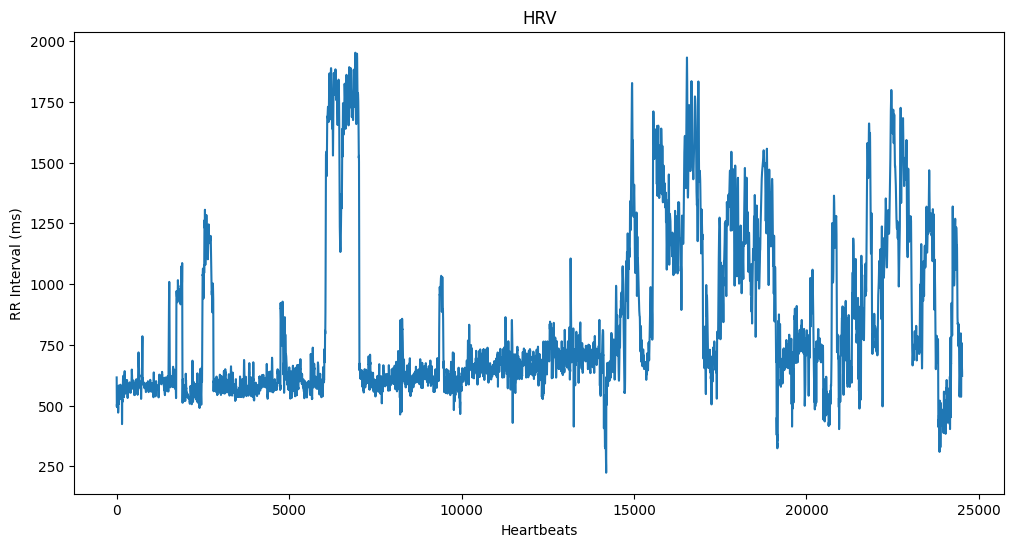

In [128]:
import matplotlib.pyplot as plt
# Plotting a sample of the generated HRV data
plt.figure(figsize=(12, 6))
# plt.plot(hrv_data[:2000])  # Plotting a smaller sample for better visibility
plt.plot(rr_df['RR_Interval'])
plt.title("HRV")
plt.xlabel("Heartbeats")
plt.ylabel("RR Interval (ms)")
plt.show()